# Convert Bylot forcing files to CLASSIC
https://cccma.gitlab.io/classic/makeInputFiles.html

In [1]:
# Env: sc2_v0

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
import os

## Bylot Island, Canadian high Arctic

The site is a low-center polygon, with herb tundra and no erect vegetation

| Short name | byl |
|:-----------|:----|
| Location | 73.1504ºN, 80.0046ºW |
| Elevation | 25 m |
| Snow-free albedo | - |
| Simulation period | 11 July 2013 to 25 June 2019 |
| Temperature/humidity measurement height | 2.3 m |
| Wind measurement height | 2.3 m |
| Reference | Domine et al. ([2021](https://essd.copernicus.org/articles/13/4331/2021/)) |

In [3]:
site = 'byl'

year_start = '2013'
year_end = '2019'

lat = 73.1504
lon = -80.0046

path = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot'
path_tmp = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/tmp'
path_out = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/'+site
path_out_CLASSIC = '/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/'+site+'/forcing'

if os.path.exists(path_out):
    print(path_out+' already exist.')
else:
    os.makedirs(path_out)
    print(path_out+' has been created!')

if os.path.exists(path_out_CLASSIC):
    print(path_out_CLASSIC+' already exist.')
else:
    os.makedirs(path_out_CLASSIC)
    print(path_out_CLASSIC+' has been created!')

/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/byl already exist.
/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/byl/forcing already exist.


### Open original forcing file

In [4]:
ds = xr.open_dataset(path+'/met_insitu_'+site+'_30min_'+year_start+'_'+year_end+'.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 104403)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-11T09:00:00 ... 2019-06-25T10:00:00
Data variables:
    Wind     (time) float64 ...
    Tair     (time) float64 ...
    Qair     (time) float64 ...
    LWdown   (time) float64 ...
    SWdown   (time) float64 ...
    Psurf    (time) float64 ...
    Rainf    (time) float64 ...
    Snowf    (time) float64 ...

In [5]:
ds.time.encoding

{'zlib': False,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': True,
 'chunksizes': None,
 'source': '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot/met_insitu_byl_30min_2013_2019.nc',
 'original_shape': (104403,),
 'dtype': dtype('int64'),
 'units': 'minutes since 2013-07-11 09:00:00',
 'calendar': 'proleptic_gregorian'}

In [6]:
# Check if there are leap years
ds.sel(time='2016-02')

<xarray.Dataset>
Dimensions:  (time: 1392)
Coordinates:
  * time     (time) datetime64[ns] 2016-02-01 ... 2016-02-29T23:30:00
Data variables:
    Wind     (time) float64 ...
    Tair     (time) float64 ...
    Qair     (time) float64 ...
    LWdown   (time) float64 ...
    SWdown   (time) float64 ...
    Psurf    (time) float64 ...
    Rainf    (time) float64 ...
    Snowf    (time) float64 ...

### Slice file to full years (as CLASSIC expect only full years)
It is not required as long as you only use the full years in the job file

In [7]:
year_start_full = str(int(year_start) + 1)
year_end_full = str(int(year_end) - 1)

ds_subset = ds.sel(time=slice(year_start_full, year_end_full))
ds_subset

<xarray.Dataset>
Dimensions:  (time: 87648)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 ... 2018-12-31T23:30:00
Data variables:
    Wind     (time) float64 ...
    Tair     (time) float64 ...
    Qair     (time) float64 ...
    LWdown   (time) float64 ...
    SWdown   (time) float64 ...
    Psurf    (time) float64 ...
    Rainf    (time) float64 ...
    Snowf    (time) float64 ...

In [8]:
ds_subset.to_netcdf(path_tmp+'/met_insitu_'+site+'_30min_'+year_start_full+'_'+year_end_full+'.nc')

### Convert time from relative to absolute
https://sourceforge.net/p/nco/discussion/9830/thread/175b4c98e1/?limit=25

The time format `day as %Y%m%d.%f` is <mark>**required** by CLASSIC</mark>

Note: you need CDO installed to run the next cell (`!` allow to run bash command in the notebook)

In [9]:
!cdo -a -f nc copy {path_tmp}/met_insitu_{site}_30min_{year_start_full}_{year_end_full}.nc {path_tmp}/met_insitu_{site}_30min_{year_start_full}_{year_end_full}_a.nc

cdo    copy:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    copy: Processed 701184 values from 8 variables over 87648 timesteps [6.93s 259MB]


## Open the new file with absolute time

In [10]:
ds = xr.open_dataset(path_tmp+'/met_insitu_'+site+'_30min_'+year_start_full+'_'+year_end_full+'_a.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 87648)
Coordinates:
  * time     (time) float64 2.014e+07 2.014e+07 ... 2.018e+07 2.018e+07
Data variables:
    Wind     (time) float64 ...
    Tair     (time) float64 ...
    Qair     (time) float64 ...
    LWdown   (time) float64 ...
    SWdown   (time) float64 ...
    Psurf    (time) float64 ...
    Rainf    (time) float64 ...
    Snowf    (time) float64 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Feb 08 14:45:28 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [11]:
ds.time

<xarray.DataArray 'time' (time: 87648)>
array([20140101.      , 20140101.020833, 20140101.041667, ..., 20181231.9375  ,
       20181231.958333, 20181231.979167])
Coordinates:
  * time     (time) float64 2.014e+07 2.014e+07 ... 2.018e+07 2.018e+07
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T

### Add the lat/lon dimensions of the site (<mark>required by CLASSIC</mark>)

Note: the values of the coordinates does not seem to matter for CLASSIC (the attributes neither)

In [12]:
ds = ds.assign_coords(lon=lon)
ds = ds.expand_dims('lon')
ds['lon'] = ds.lon.assign_attrs(
    standard_name='Longitude',
    units='degrees_east',
    axis='X'
)

ds = ds.assign_coords(lat=lat)
ds = ds.expand_dims('lat')
ds['lat'] = ds.lat.assign_attrs(
    standard_name='Latitude',
    units='degrees_north',
    axis='Y'
)

# Transpose the dimension to put the time first (as required by CLASSIC)
ds = ds.transpose('time', 'lat', 'lon')

ds

<xarray.Dataset>
Dimensions:  (time: 87648, lat: 1, lon: 1)
Coordinates:
  * time     (time) float64 2.014e+07 2.014e+07 ... 2.018e+07 2.018e+07
  * lon      (lon) float64 -80.0
  * lat      (lat) float64 73.15
Data variables:
    Wind     (time, lat, lon) float64 0.134 0.105 0.076 ... 1.0 0.369 0.271
    Tair     (time, lat, lon) float64 -39.72 -39.49 -39.27 ... -28.13 -28.01
    Qair     (time, lat, lon) float64 7.51e-05 7.665e-05 ... 0.0002744 0.000275
    LWdown   (time, lat, lon) float64 162.2 162.3 162.3 ... 181.4 170.2 166.9
    SWdown   (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Psurf    (time, lat, lon) float64 1.012e+05 1.012e+05 ... 1.011e+05
    Rainf    (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Snowf    (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Feb 08 14:45:28 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

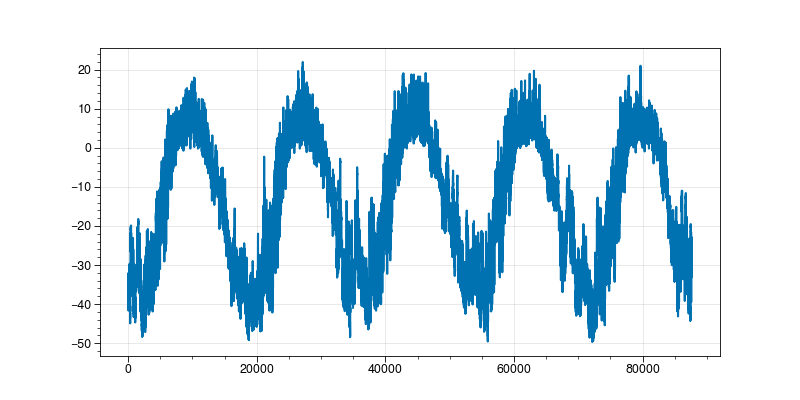

In [13]:
%matplotlib widget
plt.figure(figsize=(8,4))
plt.plot(ds.Tair.squeeze().values)

### Add Rainf and Snowf (<mark>required by CLASSIC</mark>)

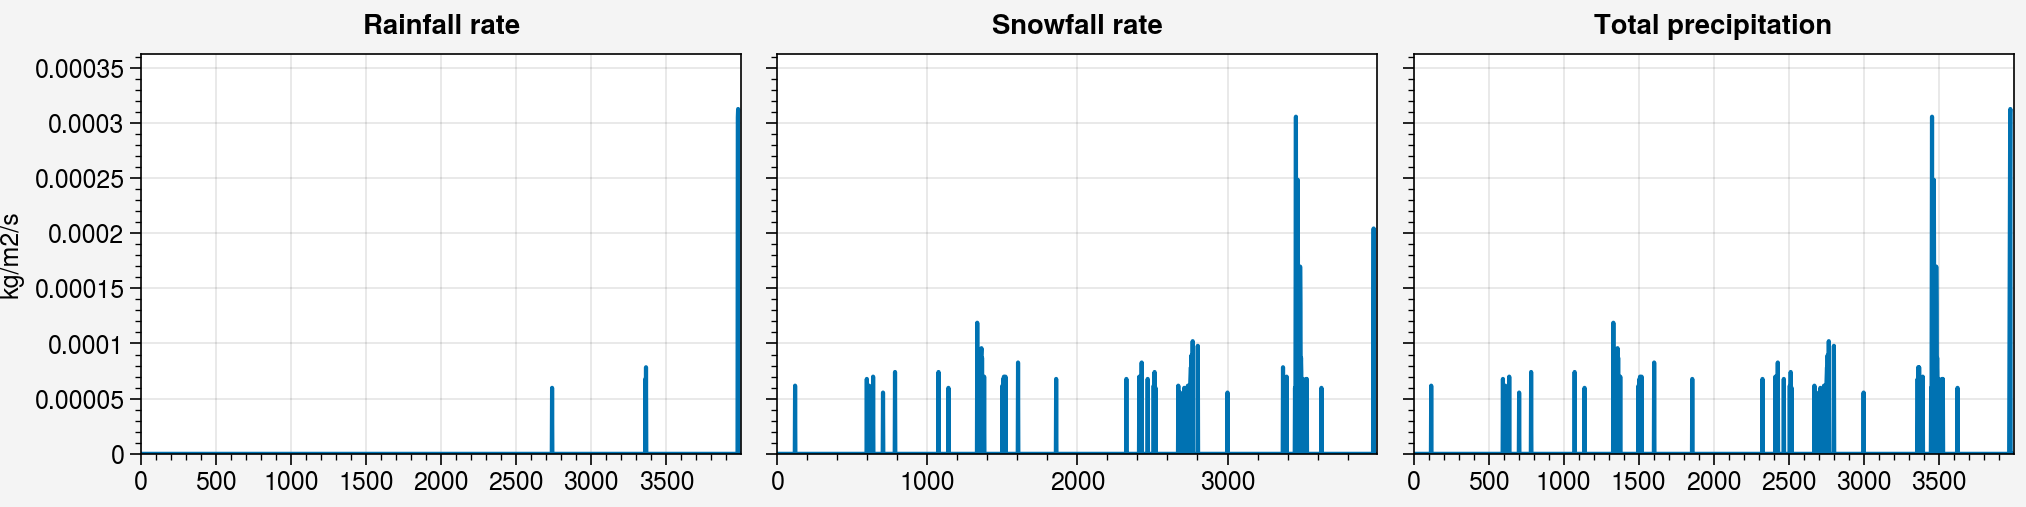

In [15]:
%matplotlib inline
fig, axs = pplt.subplots(ncols=3, nrows=1, refaspect=1.5, refwidth=3)

i_start = 1500*2
i_end = 3500*2

axs[0].plot(ds.Rainf.squeeze().values[i_start:i_end])
axs[1].plot(ds.Snowf.squeeze().values[i_start:i_end])
axs[2].plot(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end])

for ax in axs:
    ax.format(
        ylabel=ds.Rainf.attrs['units'], 
        ylim=(0,max(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end]).item(0) + 0.00005)
    )
    
axs.format(
    collabels=[ds.Rainf.attrs['long_name'], ds.Snowf.attrs['long_name'], 'Total precipitation']
)


In [16]:
ds['TotPrecip'] = ds.Rainf + ds.Snowf
ds.TotPrecip.attrs['long_name'] = 'Total precipitaion rate (Rainf + Snowf)'
ds.TotPrecip.attrs['units'] = ds.Rainf.attrs['units']
ds

<xarray.Dataset>
Dimensions:    (time: 87648, lat: 1, lon: 1)
Coordinates:
  * time       (time) float64 2.014e+07 2.014e+07 ... 2.018e+07 2.018e+07
  * lon        (lon) float64 -80.0
  * lat        (lat) float64 73.15
Data variables:
    Wind       (time, lat, lon) float64 0.134 0.105 0.076 ... 1.0 0.369 0.271
    Tair       (time, lat, lon) float64 -39.72 -39.49 -39.27 ... -28.13 -28.01
    Qair       (time, lat, lon) float64 7.51e-05 7.665e-05 ... 0.000275
    LWdown     (time, lat, lon) float64 162.2 162.3 162.3 ... 181.4 170.2 166.9
    SWdown     (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Psurf      (time, lat, lon) float64 1.012e+05 1.012e+05 ... 1.011e+05
    Rainf      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Snowf      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TotPrecip  (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Feb 08 14:45:28 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

## Save forcing files

CLASSIC **requires** <mark>one file per forcing variable</mark>

Note: I save the files directly to CLASSIC folder and here to keep more flexibility in the future

In [17]:
for key in list(ds.keys()):
    ds[key].to_netcdf(path_out+'/met_insitu_'+site+'_30min_'+year_start_full+'_'+year_end_full+'_'+key+'.nc')
    ds[key].to_netcdf(path_out_CLASSIC+'/met_insitu_'+site+'_30min_'+year_start_full+'_'+year_end_full+'_'+key+'.nc')

In [18]:
!ls {path_out}

met_insitu_byl_1.3SWd_2014_2018_LWdown.nc
met_insitu_byl_1.3SWd_2014_2018_Psurf.nc
met_insitu_byl_1.3SWd_2014_2018_Qair.nc
met_insitu_byl_1.3SWd_2014_2018_Rainf.nc
met_insitu_byl_1.3SWd_2014_2018_Snowf.nc
met_insitu_byl_1.3SWd_2014_2018_SWdown.nc
met_insitu_byl_1.3SWd_2014_2018_Tair.nc
met_insitu_byl_1.3SWd_2014_2018_TotPrecip.nc
met_insitu_byl_1.3SWd_2014_2018_Wind.nc
met_insitu_byl_2014_2018_LWdown.nc
met_insitu_byl_2014_2018_Psurf.nc
met_insitu_byl_2014_2018_Qair.nc
met_insitu_byl_2014_2018_Rainf.nc
met_insitu_byl_2014_2018_Snowf.nc
met_insitu_byl_2014_2018_SWdown.nc
met_insitu_byl_2014_2018_Tair.nc
met_insitu_byl_2014_2018_TotPrecip.nc
met_insitu_byl_2014_2018_Wind.nc
met_insitu_byl_30min_2014_2018_LWdown.nc
met_insitu_byl_30min_2014_2018_Psurf.nc
met_insitu_byl_30min_2014_2018_Qair.nc
met_insitu_byl_30min_2014_2018_Rainf.nc
met_insitu_byl_30min_2014_2018_Snowf.nc
met_insitu_byl_30min_2014_2018_SWdown.nc
met_insitu_byl_30min_2014_2018_Tair.nc
met_insitu_byl_30min_2014_2018_TotPreci

In [19]:
!ls {path_out_CLASSIC}

met_insitu_byl_1.3SWd_2014_2018_LWdown.nc
met_insitu_byl_1.3SWd_2014_2018_Psurf.nc
met_insitu_byl_1.3SWd_2014_2018_Qair.nc
met_insitu_byl_1.3SWd_2014_2018_Rainf.nc
met_insitu_byl_1.3SWd_2014_2018_Snowf.nc
met_insitu_byl_1.3SWd_2014_2018_SWdown.nc
met_insitu_byl_1.3SWd_2014_2018_Tair.nc
met_insitu_byl_1.3SWd_2014_2018_TotPrecip.nc
met_insitu_byl_1.3SWd_2014_2018_Wind.nc
met_insitu_byl_2014_2018_LWdown.nc
met_insitu_byl_2014_2018_Psurf.nc
met_insitu_byl_2014_2018_Qair.nc
met_insitu_byl_2014_2018_Rainf.nc
met_insitu_byl_2014_2018_Snowf.nc
met_insitu_byl_2014_2018_SWdown.nc
met_insitu_byl_2014_2018_Tair.nc
met_insitu_byl_2014_2018_TotPrecip.nc
met_insitu_byl_2014_2018_Wind.nc
met_insitu_byl_30min_2014_2018_LWdown.nc
met_insitu_byl_30min_2014_2018_Psurf.nc
met_insitu_byl_30min_2014_2018_Qair.nc
met_insitu_byl_30min_2014_2018_Rainf.nc
met_insitu_byl_30min_2014_2018_Snowf.nc
met_insitu_byl_30min_2014_2018_SWdown.nc
met_insitu_byl_30min_2014_2018_Tair.nc
met_insitu_byl_30min_2014_2018_TotPreci

In [20]:
path_init = '/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/'+site
exp2 = '30min'
!cp {path_init}/{site}_init_run_Ref.nc {path_init}/{site}_init_run_{exp2}.nc
!cp {path_init}/rsfile_run_Ref.nc {path_init}/rsfile_run_{exp2}.nc


In [21]:
!mkdir /home/lalandmi/eccc/classic-develop/outputFiles/SnowArctic/{site}/run_{exp2}